# Brain Tumor Detection

### By: [Ogunleye Toluwalashe](http://github.com/Toluwaa-o)
### Tools: TensorFlow, Python, Kaggle, Machine Learning, Neural Networks, e.t.c

First, import all the libraries we will be using in this project.

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from skimage.transform import resize

random.seed(2)

# Data Fetching

The dataset contains two folders, 'train' and 'test'. We are going to store the 'train' path as a variable so we can use it in our function.

In [2]:
train_images_path = './train'

The train folder also contains two folders. The 'no' folder (for images that don't have a tumor) and the 'yes' folder for images that have a tumor. We are going to create a function to iterate over both folders and read all the images, while also storing the corresponding label (1: for yes and 0: for no). At the end of the function, we return the list containing our data.

In [3]:
def get_all_images(url):
    ds = []
    
    for cls in os.listdir(url):
        new_path = os.path.join(url, cls)
        for im in os.listdir(new_path):
            
            img_path = os.path.join(new_path, im)
            img = cv2.imread(img_path)
            
            # Reshape the images because the sizes are inconsistent
            resized_img = resize(img, (128, 128, 3))
            label = 1 if cls == 'yes' else 0
            ds.append((np.array(resized_img), label))
    return ds      

Next, we call the funtion and store it in a variable called 'ds'

In [4]:
ds = get_all_images(train_images_path)

Next, we explore the length and shape of the data we received to make sure everything is stored properly.

In [5]:
len(ds), ds[0][0].shape

(7012, (128, 128, 3))

# Data Preprocessing

Next, we shuffle the data to ensure there is an element of randomness in the data the model receives

In [6]:
np.random.shuffle(ds)

### Splitting the data into training and validation data

Next, we are going to get the total size of the data and then divide it 0.9-0.1. 0.9 for training and the remaining data for validation.

In [7]:
sample_size = len(ds)

train_size = int(0.9 * sample_size)
valid_size = sample_size - train_size

Next, we store our images and labels in separate variables

In [8]:
ds_images = [obv[0] for obv in ds]
ds_labels = np.array([obv[1] for obv in ds])

After that, we visualized the first 5 images in the dataset, just to visualize our data. We also set the label as the title.

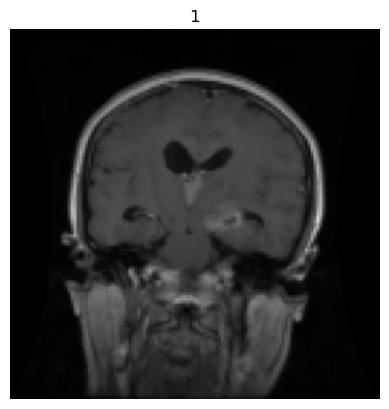

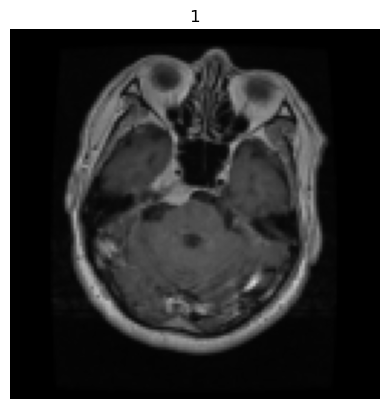

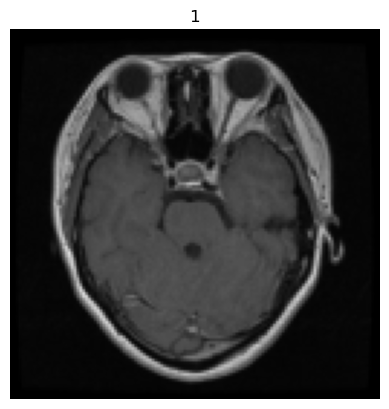

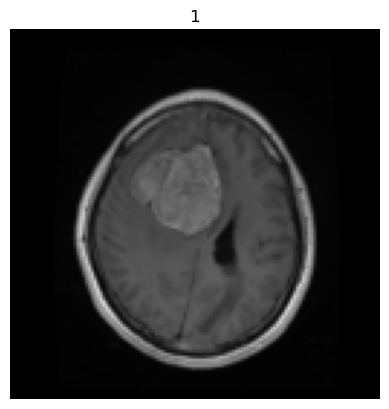

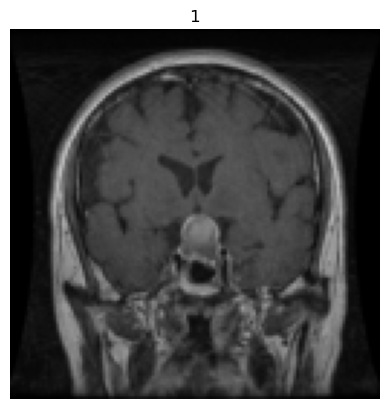

In [9]:
for num in range(0,5):
    plt.imshow(ds_images[num])
    plt.title(ds_labels[num])
    plt.axis('off')
    plt.show()

Next, split the inputs and labels into different variables

In [10]:
train_imgs = ds_images[:train_size]
train_labels = ds_labels[:train_size]

valid_imgs = ds_images[train_size:]
valid_labels = ds_labels[train_size:]

We check the length of training and validation variables to make sure it was properly split 0.9-0.1.

In [11]:
len(train_labels), len(valid_imgs)

(6310, 702)

### Caching the data, so we can feed it to the model in batches and thereby use less space

Next steps include converting the dataset into a tensor dataset so we can cache it. After we have done that, we cache it in batches of 16.

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_labels))

In [13]:
batch_size = 16

train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Creation

Now that we are done preparing the data, we can now create our model.
- The first layer in the model rescales the data, so that the values are between 0 and 1.
- This model involves 3 convolutional layers. One depthwise convolutional layer and two regular convolutional layers.
- The first regular convolutional layer applies 50 filters and the second one applies 25 filters
- We use the 'relu' activation function in those layers.
- It also includes two maxpooling layers, that use a 2/2 window when extracting information.
- After all these layers, we flatten the data. Then the data passes through a dense layer with 25 neurons before the output layer
- The output is binary so the output layer only expects 1 value

In [14]:
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.DepthwiseConv2D((3,3), activation='relu', strides=(2,2), padding='same'))
model.add(layers.Conv2D(50, (3,3), activation="relu", input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(25, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

c:\Users\Owner\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


After creating the model architecture, we compile it. 
- We use the Adam optimizer, with a learning rate of 0.001
- The binary crossentropy loss function (because we are dealing with binary output). From logits is also set to true so that it doesnt output probabilities
- We also set accuracy as the metric because this is a classification problem.
- After that we fit the model, and it runs for the preset number of epochs (50)

In [15]:
lr = 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 50

model.fit(
    train_ds,
    epochs = epochs,
    validation_data = valid_ds,
    verbose = 2
)

Epoch 1/50
395/395 - 88s - 223ms/step - accuracy: 0.5929 - loss: 0.6781 - val_accuracy: 0.5698 - val_loss: 0.6897
Epoch 2/50
395/395 - 19s - 49ms/step - accuracy: 0.6697 - loss: 0.6064 - val_accuracy: 0.8162 - val_loss: 0.4523
Epoch 3/50
395/395 - 19s - 47ms/step - accuracy: 0.8399 - loss: 0.3851 - val_accuracy: 0.8462 - val_loss: 0.3418
Epoch 4/50
395/395 - 19s - 47ms/step - accuracy: 0.8962 - loss: 0.2803 - val_accuracy: 0.8632 - val_loss: 0.3234
Epoch 5/50
395/395 - 20s - 50ms/step - accuracy: 0.9147 - loss: 0.2371 - val_accuracy: 0.8832 - val_loss: 0.2814
Epoch 6/50
395/395 - 20s - 51ms/step - accuracy: 0.9250 - loss: 0.2166 - val_accuracy: 0.9088 - val_loss: 0.2486
Epoch 7/50
395/395 - 20s - 51ms/step - accuracy: 0.9300 - loss: 0.2027 - val_accuracy: 0.9245 - val_loss: 0.2150
Epoch 8/50
395/395 - 19s - 49ms/step - accuracy: 0.9331 - loss: 0.1911 - val_accuracy: 0.9330 - val_loss: 0.1873
Epoch 9/50
395/395 - 19s - 48ms/step - accuracy: 0.9372 - loss: 0.1781 - val_accuracy: 0.9402 -

- After 50 Epochs, our model stops. We have a training accuracy of 99.8% and a loss of just 0.0073. This is very good.
- To make sure our model didn't just overfit, we check the validation details as well
- We have a validation accuracy of 97.3% and a loss of 0.2. This means our model overfitted by a little, but this is not a problem as the difference is not substancial.

Next, we save the model so we can access it later

In [16]:
model.save('Brain_Tumor_Model.keras')

# Testing the Model

The final step is to test our model, and the dataset already comes with training data so we are going to use that

We follow the steps we used in preprocessing the training data and we preprocess the test data as well.

In [3]:
model = tf.keras.models.load_model('Brain_Tumor_Model.keras')

In [17]:
test_images = './test'

In [18]:
test_images = get_all_images(test_images)

In [19]:
test_imgs = [obv[0] for obv in test_images]
test_labels = np.array([obv[1] for obv in test_images])

In [20]:
batch_size = 16

test_ds = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels))
test_ds = test_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

Now that preprocessing is done, we can finally test our model

In [21]:
loss, accuracy = model.evaluate(test_ds)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9741 - loss: 0.3542


After testing the model, we see that we have a test accuracy of 97.4% and a loss of 0.4.

In conclusion, the aim of this project was to create a model that could accurately tell us if a tumor is present in a person's brain through brain scan images and we have successfully done that. We have created a model that can classify brain tumor images with an accuracy of 97.4%!.